In [1]:
import sklearn
import sys

sklearn.__version__

'1.0.2'

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import re
import math
from sklearn.preprocessing import RobustScaler, StandardScaler

In [272]:

CLIP_FEATURES = ["feature01", "feature04", "feature05", "feature07", "feature19", "feature20", "feature21", "feature22",
                 "feature23", "feature24", "feature25", "feature26", "feature27", "feature28", "feature29", "feature30",
                 "feature31"]
LOG_SCALATION_FEATURES = ["feature02", "feature03", "feature34", "feature36"]

def normalizeCurrentAge(data_frame):
    current_dataframe = data_frame.copy()
    current_dataframe["current_age"] = (data_frame["current_age"]-MINS["current_age"])/(MAXS["current_age"]-MINS["current_age"])
    return current_dataframe
    
def normalizeVoiceFeaturesMINMAX(data_frame):
    pattern = re.compile("feature")
    current_dataframe = data_frame.copy()
    for elem in current_dataframe.keys():
        if (pattern.match(elem)) is not None and elem not in LOG_SCALATION_FEATURES:
            current_dataframe[elem] = (current_dataframe[elem]-MINS[elem])/(MAXS[elem]-MINS[elem])
    return current_dataframe

def normalizeVoiceFeaturesLOG(data_frame): #OLD
    current_dataframe = data_frame.copy()
    for elem in current_dataframe.keys():
        if elem in LOG_SCALATION_FEATURES:
            for idx in range(len(elem)):
                if current_dataframe[elem][idx] == 0.0:
                    current_dataframe[elem][idx] = -10000
                else:
                    #print(current_dataframe[elem][idx])
                    current_dataframe[elem][idx] = math.log(current_dataframe[elem][idx])
    return current_dataframe

def normalizeVoiceFeaturesROBUST(data_frame):
    pattern = re.compile("feature")
    current_dataframe = data_frame.copy()
    for elem in LOG_SCALATION_FEATURES:
        transformer = StandardScaler()
        current_dataframe[elem] = transformer.fit_transform(current_dataframe[[elem]])
        current_dataframe[elem] = transformer.transform(current_dataframe[[elem]])
    return current_dataframe
    
def normalizeSex(data_frame):
    current_dataframe = data_frame.copy().reset_index()
    n_sex = []
    for index in range(len(current_dataframe)):
        if current_dataframe["sex"][index] == "M":
            n_sex.append(0)
        else:
            n_sex.append(1)
    current_dataframe["sex"] = n_sex
    del current_dataframe["index"]
    return current_dataframe
    
def getDataFrameFeatures(data_frame):
    pattern = re.compile("feature")
    features_keys = ["sex", "current_age"]
    for elem in data_frame.keys():
        if (pattern.match(elem)) is not None:
            features_keys.append(elem)
    features_frame = data_frame[features_keys]
    #features_frame = normalizeVoiceFeaturesMINMAX(features_frame)
    ##features_frame = normalizeVoiceFeaturesROBUST(features_frame)
    #features_frame = normalizeCurrentAge(features_frame)
    features_frame = normalizeSex(features_frame)
    return features_frame

def getDataFrameLabels(data_frame):
    C0 = [1,0,0,0]
    C1 = [0,1,0,0]
    C2 = [0,0,1,0]
    C3 = [0,0,0,1]
    data_labels = []
    data_frame.head()
    heads = ["memory", "hallucinations", "mood", "motivation", "speech", "saliva", 
             "swallowing", "handwriting","dressing", "cutting_food", "hygiene", "turning_in_bed", "falling", "freezing", "walking", "tremors", "numbness" ]
    for index, row in data_frame.iterrows():
        addition = 0
        for elem in heads:
            addition = addition + row[elem]
        if (addition == 0):
            #data_labels.append(C0)
            data_labels.append(C1)
        elif (addition > 0 and addition <= 10):
            data_labels.append(C1)
        elif (addition > 10 and addition <= 17):
            data_labels.append(C2)
        else:
            data_labels.append(C3)
    return data_labels


def checkAgeIsGraterThanSysptoms(data_frame):
    valid_data_frame = data_frame.copy().reset_index()
    indexes = []
    for index in range(len(valid_data_frame)):
        if valid_data_frame["current_age"][index] < valid_data_frame["years_since_first_symptom"][index] or valid_data_frame["current_age"][index] < 20:
            indexes.append(index)
    valid_data_frame.drop(indexes)
    del valid_data_frame["index"]
    return valid_data_frame
    
def eliminateBadVoiceCodeElements(data_frame):
    valid_voice_code_elemnts = data_frame.copy()
    valid_voice_code_elemnts = valid_voice_code_elemnts.drop(valid_voice_code_elemnts[valid_voice_code_elemnts["voice_code"] == "bad" ].index)
    return valid_voice_code_elemnts

def eliminateEmptySexElements(data_frame):
    valid_voice_code_elemnts = data_frame.copy()
    valid_voice_code_elemnts = valid_voice_code_elemnts.drop(valid_voice_code_elemnts[valid_voice_code_elemnts["voice_code"] == "" ].index)
    return valid_voice_code_elemnts

def cleanDataFrame(data_frame):
    clean_data_frame = data_frame.copy()
    #clean_data_frame = clean_data_frame.dropna()
    clean_data_frame = eliminateBadVoiceCodeElements(clean_data_frame)
    clean_data_frame = eliminateEmptySexElements(clean_data_frame)
    clean_data_frame = checkAgeIsGraterThanSysptoms(clean_data_frame)
    return clean_data_frame


#esta función proviene del libro Hands on Machine Learning con nombre split_train_test
def split_dataset(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

def getMaxsAndMins(data_frame):
    NUMERICAL_TYPES = ["int64", "float64"]
    maxs = {}
    mins = {}
    current_dataframe = data_frame.copy().reset_index()
    for elem in current_dataframe.keys():
        if current_dataframe.dtypes[elem] in NUMERICAL_TYPES:
            maxs[elem] = current_dataframe[elem].max()
            mins[elem] = current_dataframe[elem].min()
    return maxs, mins


In [273]:
def load_data(file_name):
    return pd.read_csv( "datos/"+ file_name + ".csv")

ALL_DATA = pd.concat([load_data("plmpva_train"),load_data("plmpva_test-NoPDRS")])
MAXS, MINS = getMaxsAndMins(cleanDataFrame(ALL_DATA))
TRAIN_DATA, VALIDATION_DATA = split_dataset(cleanDataFrame(ALL_DATA), 0.2)
TRAIN_DATA , TEST_DATA = split_dataset(TRAIN_DATA, 0.2)
TRAIN_FEATURES = getDataFrameFeatures(TRAIN_DATA)
TRAIN_LABELS = getDataFrameLabels(TRAIN_DATA)
TEST_FEATURES = getDataFrameFeatures(cleanDataFrame(TEST_DATA))
TEST_LABELS = getDataFrameLabels(cleanDataFrame(TEST_DATA))
VALIDATION_FEATURES = getDataFrameFeatures(cleanDataFrame(VALIDATION_DATA))
VALIDATION_LABELS = getDataFrameLabels(cleanDataFrame(VALIDATION_DATA))

In [258]:
len(TRAIN_DATA)

460

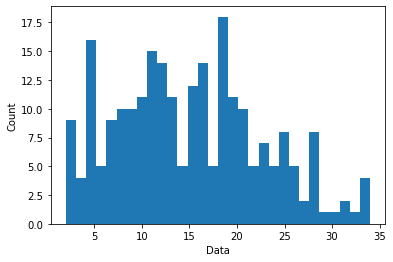

In [31]:
from matplotlib import pyplot as plt
plt.hist(TRAIN_LABELS, density=False, bins=30)  # density=False would make counts
plt.ylabel('Count')
plt.xlabel('Data');

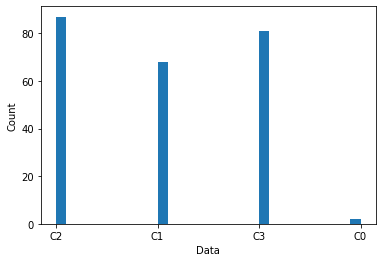

In [60]:
from matplotlib import pyplot as plt
plt.hist(TRAIN_LABELS, density=False, bins=30)  # density=False would make counts
plt.ylabel('Count')
plt.xlabel('Data');

In [158]:
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPool1D , Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy, CategoricalAccuracy, PrecisionAtRecall, TruePositives, TrueNegatives, FalsePositives, FalseNegatives

In [265]:
TRAIN_ARRAY = np.expand_dims(TRAIN_FEATURES.to_numpy(), axis=2)
TRAIN_LABELS_ARRAY = np.expand_dims(np.array(TRAIN_LABELS), axis=2) #tf.convert_to_tensor(TRAIN_LABELS)
VALIDATION_ARRAY = np.expand_dims(VALIDATION_FEATURES.to_numpy(), axis=2) #tf.convert_to_tensor(VALIDATION_FEATURES)
VALIDATION_LABELS_ARRAY = np.expand_dims(np.array(VALIDATION_LABELS), axis=2) #tf.convert_to_tensor(VALIDATION_LABELS)
TEST_ARRAY = np.expand_dims(TEST_FEATURES.to_numpy(), axis=2) #tf.convert_to_tensor(TEST_FEATURES)
TEST_LABELS_ARRAY = np.expand_dims(np.array(TEST_LABELS), axis=2) #tf.convert_to_tensor(TEST_LABELS)

In [163]:
model = Sequential()
model.add(Conv1D(input_shape=TRAIN_ARRAY.shape[1:],filters=64,kernel_size=(3),padding="same", activation="relu"))
model.add(Conv1D(filters=64,kernel_size=(3),padding="same", activation="relu"))
model.add(MaxPool1D(pool_size=(2),strides=(2)))
model.add(Conv1D(filters=128, kernel_size=(3), padding="same", activation="relu"))
model.add(Conv1D(filters=128, kernel_size=(3), padding="same", activation="relu"))
model.add(MaxPool1D(pool_size=(2),strides=(2)))
model.add(Conv1D(filters=256, kernel_size=(3), padding="same", activation="relu"))
model.add(Conv1D(filters=256, kernel_size=(3), padding="same", activation="relu"))
model.add(Conv1D(filters=256, kernel_size=(3), padding="same", activation="relu"))
model.add(MaxPool1D(pool_size=(2),strides=(2)))
model.add(Conv1D(filters=512, kernel_size=(3), padding="same", activation="relu"))
model.add(Conv1D(filters=512, kernel_size=(3), padding="same", activation="relu"))
model.add(Conv1D(filters=512, kernel_size=(3), padding="same", activation="relu"))
model.add(MaxPool1D(pool_size=(2),strides=(2)))
model.add(Conv1D(filters=512, kernel_size=(3), padding="same", activation="relu"))
model.add(Conv1D(filters=512, kernel_size=(3), padding="same", activation="relu"))
model.add(Conv1D(filters=512, kernel_size=(3), padding="same", activation="relu"))
model.add(MaxPool1D(pool_size=(2),strides=(2)))
model.add(Flatten())
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4, activation="softmax"))
model.compile(optimizer=Adam(learning_rate=1e-3), loss=keras.losses.categorical_crossentropy, metrics=[CategoricalAccuracy(), Accuracy()])
#res = model.fit(x=TRAIN_ARRAY, y=TRAIN_LABELS_ARRAY, epochs=10, verbose=2, validation_data = (VALIDATION_ARRAY, VALIDATION_LABELS_ARRAY))

In [274]:
model = Sequential() 
model.add(Dropout(.2, input_shape=TRAIN_ARRAY.shape[1:]))
model.add(Conv1D(filters=64,kernel_size=(3),padding="same", activation="relu"))
model.add(Conv1D(filters=64,kernel_size=(3),padding="same", activation="relu"))
model.add(MaxPool1D(pool_size=(2),strides=(2),padding="same"))
model.add(Conv1D(filters=128, kernel_size=(3), padding="same", activation="relu"))
model.add(Conv1D(filters=128, kernel_size=(3), padding="same", activation="relu"))
model.add(MaxPool1D(pool_size=(2),strides=(2)))
model.add(Flatten())
model.add(Dense(units=700,activation="relu"))
model.add(Dense(units=700,activation="relu"))
model.add(Dense( units=4, activation= "softmax"))
model.compile(optimizer=Adam(learning_rate=3e-3), loss=keras.losses.categorical_crossentropy, metrics=[CategoricalAccuracy(), Accuracy()])
res = model.fit(x=TRAIN_ARRAY, y=TRAIN_LABELS_ARRAY, epochs=200, verbose=2, validation_data = (VALIDATION_ARRAY, VALIDATION_LABELS_ARRAY), callbacks=[model_checkpoint_callback])

Epoch 1/200
15/15 - 1s - loss: 5.2085 - categorical_accuracy: 0.5739 - accuracy: 0.0337 - val_loss: 1.5926 - val_categorical_accuracy: 0.6783 - val_accuracy: 0.0070 - 1s/epoch - 84ms/step
Epoch 2/200
15/15 - 0s - loss: 1.0577 - categorical_accuracy: 0.6565 - accuracy: 5.4348e-04 - val_loss: 0.9395 - val_categorical_accuracy: 0.6783 - val_accuracy: 0.0000e+00 - 292ms/epoch - 19ms/step
Epoch 3/200
15/15 - 0s - loss: 0.9322 - categorical_accuracy: 0.6609 - accuracy: 5.4348e-04 - val_loss: 0.9139 - val_categorical_accuracy: 0.6783 - val_accuracy: 0.0000e+00 - 285ms/epoch - 19ms/step
Epoch 4/200
15/15 - 0s - loss: 0.8948 - categorical_accuracy: 0.6696 - accuracy: 0.0000e+00 - val_loss: 0.9134 - val_categorical_accuracy: 0.6783 - val_accuracy: 0.0000e+00 - 276ms/epoch - 18ms/step
Epoch 5/200
15/15 - 0s - loss: 0.8978 - categorical_accuracy: 0.6717 - accuracy: 0.0000e+00 - val_loss: 0.8864 - val_categorical_accuracy: 0.6783 - val_accuracy: 0.0000e+00 - 293ms/epoch - 20ms/step
Epoch 6/200
15/1

Epoch 43/200
15/15 - 0s - loss: 0.8443 - categorical_accuracy: 0.6717 - accuracy: 0.0000e+00 - val_loss: 0.8658 - val_categorical_accuracy: 0.6783 - val_accuracy: 0.0000e+00 - 270ms/epoch - 18ms/step
Epoch 44/200
15/15 - 0s - loss: 0.8439 - categorical_accuracy: 0.6717 - accuracy: 0.0000e+00 - val_loss: 0.8689 - val_categorical_accuracy: 0.6783 - val_accuracy: 0.0000e+00 - 275ms/epoch - 18ms/step
Epoch 45/200
15/15 - 0s - loss: 0.8491 - categorical_accuracy: 0.6717 - accuracy: 0.0000e+00 - val_loss: 0.8971 - val_categorical_accuracy: 0.6783 - val_accuracy: 0.0000e+00 - 287ms/epoch - 19ms/step
Epoch 46/200
15/15 - 0s - loss: 0.8745 - categorical_accuracy: 0.6717 - accuracy: 0.0022 - val_loss: 0.8705 - val_categorical_accuracy: 0.6783 - val_accuracy: 0.0000e+00 - 261ms/epoch - 17ms/step
Epoch 47/200
15/15 - 0s - loss: 0.8609 - categorical_accuracy: 0.6717 - accuracy: 0.0000e+00 - val_loss: 0.8715 - val_categorical_accuracy: 0.6783 - val_accuracy: 0.0000e+00 - 283ms/epoch - 19ms/step
Epoc

Epoch 84/200
15/15 - 0s - loss: 0.8509 - categorical_accuracy: 0.6717 - accuracy: 0.0000e+00 - val_loss: 0.8658 - val_categorical_accuracy: 0.6783 - val_accuracy: 0.0000e+00 - 280ms/epoch - 19ms/step
Epoch 85/200
15/15 - 0s - loss: 0.8417 - categorical_accuracy: 0.6739 - accuracy: 0.0000e+00 - val_loss: 0.8713 - val_categorical_accuracy: 0.6783 - val_accuracy: 0.0000e+00 - 318ms/epoch - 21ms/step
Epoch 86/200
15/15 - 0s - loss: 0.8391 - categorical_accuracy: 0.6717 - accuracy: 0.0000e+00 - val_loss: 0.8585 - val_categorical_accuracy: 0.6783 - val_accuracy: 0.0000e+00 - 330ms/epoch - 22ms/step
Epoch 87/200
15/15 - 0s - loss: 0.8410 - categorical_accuracy: 0.6717 - accuracy: 0.0000e+00 - val_loss: 0.8642 - val_categorical_accuracy: 0.6783 - val_accuracy: 0.0000e+00 - 271ms/epoch - 18ms/step
Epoch 88/200
15/15 - 0s - loss: 0.8534 - categorical_accuracy: 0.6696 - accuracy: 0.0000e+00 - val_loss: 0.8581 - val_categorical_accuracy: 0.6783 - val_accuracy: 0.0000e+00 - 281ms/epoch - 19ms/step


Epoch 125/200
15/15 - 0s - loss: 0.8199 - categorical_accuracy: 0.6739 - accuracy: 0.0000e+00 - val_loss: 0.8680 - val_categorical_accuracy: 0.6783 - val_accuracy: 0.0000e+00 - 274ms/epoch - 18ms/step
Epoch 126/200
15/15 - 0s - loss: 0.8158 - categorical_accuracy: 0.6761 - accuracy: 0.0000e+00 - val_loss: 0.8589 - val_categorical_accuracy: 0.6783 - val_accuracy: 0.0000e+00 - 255ms/epoch - 17ms/step
Epoch 127/200
15/15 - 0s - loss: 0.8214 - categorical_accuracy: 0.6761 - accuracy: 0.0000e+00 - val_loss: 0.8600 - val_categorical_accuracy: 0.6783 - val_accuracy: 0.0000e+00 - 291ms/epoch - 19ms/step
Epoch 128/200
15/15 - 0s - loss: 0.8350 - categorical_accuracy: 0.6652 - accuracy: 0.0000e+00 - val_loss: 0.8710 - val_categorical_accuracy: 0.6783 - val_accuracy: 0.0000e+00 - 289ms/epoch - 19ms/step
Epoch 129/200
15/15 - 0s - loss: 0.8175 - categorical_accuracy: 0.6761 - accuracy: 0.0000e+00 - val_loss: 0.8737 - val_categorical_accuracy: 0.6783 - val_accuracy: 0.0000e+00 - 257ms/epoch - 17ms/

Epoch 166/200
15/15 - 0s - loss: 0.7892 - categorical_accuracy: 0.6891 - accuracy: 0.0000e+00 - val_loss: 0.8832 - val_categorical_accuracy: 0.6783 - val_accuracy: 0.0000e+00 - 259ms/epoch - 17ms/step
Epoch 167/200
15/15 - 0s - loss: 0.7677 - categorical_accuracy: 0.6935 - accuracy: 0.0000e+00 - val_loss: 0.9242 - val_categorical_accuracy: 0.6783 - val_accuracy: 0.0000e+00 - 269ms/epoch - 18ms/step
Epoch 168/200
15/15 - 0s - loss: 0.7753 - categorical_accuracy: 0.6826 - accuracy: 0.0000e+00 - val_loss: 1.0532 - val_categorical_accuracy: 0.6783 - val_accuracy: 0.0017 - 277ms/epoch - 18ms/step
Epoch 169/200
15/15 - 0s - loss: 0.7927 - categorical_accuracy: 0.6891 - accuracy: 0.0000e+00 - val_loss: 0.9743 - val_categorical_accuracy: 0.6014 - val_accuracy: 0.0000e+00 - 261ms/epoch - 17ms/step
Epoch 170/200
15/15 - 0s - loss: 0.7846 - categorical_accuracy: 0.6761 - accuracy: 0.0000e+00 - val_loss: 0.8859 - val_categorical_accuracy: 0.6783 - val_accuracy: 0.0000e+00 - 258ms/epoch - 17ms/step

In [275]:
model.load_weights(checkpoint_filepath)

In [225]:
checkpoint_filepath = './checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

In [171]:
model.evaluate(TEST_ARRAY, TEST_LABELS_ARRAY)

2/2 [==============================] - 0s 10ms/step - loss: 2.1922 - categorical_accuracy: 0.4407 - precision_at_recall_37: 0.3353


[2.1921937465667725, 0.4406779706478119, 0.33529412746429443]

In [172]:
from sklearn import metrics
preds = model.predict(TEST_ARRAY)
matrix = metrics.confusion_matrix(TEST_LABELS_ARRAY.argmax(axis=1), preds.argmax(axis=1))
matrix

array([[11,  7,  1],
       [ 3,  8,  6],
       [ 6, 10,  7]], dtype=int64)

In [175]:
model.evaluate(TEST_ARRAY, TEST_LABELS_ARRAY)

2/2 [==============================] - 0s 8ms/step - loss: 1.6334 - categorical_accuracy: 0.4576 - precision_at_recall_38: 0.3857


[1.6334234476089478, 0.4576271176338196, 0.3857142925262451]

In [176]:
from sklearn import metrics
preds = model.predict(TEST_ARRAY)
matrix = metrics.confusion_matrix(TEST_LABELS_ARRAY.argmax(axis=1), preds.argmax(axis=1))
matrix

array([[12,  0,  7],
       [ 5,  0, 12],
       [ 8,  0, 15]], dtype=int64)

In [189]:
model.evaluate(TEST_ARRAY, TEST_LABELS_ARRAY)

2/2 [==============================] - 0s 7ms/step - loss: 5.3337 - categorical_accuracy: 0.3051 - precision_at_recall_41: 0.3415


[5.333690643310547, 0.3050847351551056, 0.3414634168148041]

In [190]:
from sklearn import metrics
preds = model.predict(TEST_ARRAY)
matrix = metrics.confusion_matrix(TEST_LABELS_ARRAY.argmax(axis=1), preds.argmax(axis=1))
matrix

array([[ 7,  5,  3],
       [ 4,  7,  9],
       [ 8, 12,  4]], dtype=int64)

In [276]:
model.evaluate(TRAIN_ARRAY, TRAIN_LABELS_ARRAY)

15/15 [==============================] - 0s 6ms/step - loss: 0.8441 - categorical_accuracy: 0.6717 - accuracy: 0.0000e+00


[0.8441227078437805, 0.6717391014099121, 0.0]

In [277]:
model.evaluate(VALIDATION_ARRAY, VALIDATION_LABELS_ARRAY)

5/5 [==============================] - 0s 6ms/step - loss: 0.8384 - categorical_accuracy: 0.6783 - accuracy: 0.0000e+00


[0.8383516669273376, 0.6783216595649719, 0.0]

In [278]:
model.evaluate(TEST_ARRAY, TEST_LABELS_ARRAY)

4/4 [==============================] - 0s 6ms/step - loss: 0.8754 - categorical_accuracy: 0.6579 - accuracy: 0.0000e+00


[0.8754374980926514, 0.6578947305679321, 0.0]

In [198]:
from sklearn import metrics
preds = model.predict(TRAIN_ARRAY)
matrix = metrics.confusion_matrix(TRAIN_LABELS_ARRAY.argmax(axis=1),
preds.argmax(axis=1))
matrix

array([[69,  0,  0],
       [ 0, 85,  0],
       [ 0,  0, 84]], dtype=int64)

In [268]:
len(TRAIN_ARRAY)

460